In [7]:
import glob
import matplotlib.pyplot as plt
import pandas as pd
from numpy.fft import fft, ifft
import numpy as np
import scipy
import seaborn as sns
import re
from tqdm.notebook import tqdm

#IMPORTING FUNCTIONS FOR CLASSIFIERS
from sklearn.model_selection import cross_val_score, train_test_split, KFold, StratifiedShuffleSplit, TimeSeriesSplit, RepeatedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelBinarizer
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn import svm
from xgboost import XGBClassifier
from sklearn.metrics import confusion_matrix

#IMPORTING FUNCTIONS FOR CLASSIFIERS METRICS
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score

#OPTMIZE PARAMETHERS
import optuna

#IMPORTING FUNCTIONS FROM ./defs

from defs import defs_copy as defs_

# Importing Database

In [8]:
samples = 1024;

df_final = pd.read_csv('df_csv/' + str(samples) + '_samples/dataframe_full', index_col=0, dtype='unicode');
df_final

,s_std_S1,psd_max_S1,mean_S1,median_S1,skew_S1,amp_max_min_S1,kurtosis_S1,s_std_S2,psd_max_S2,mean_S2,...,amp_max_min_S29,kurtosis_S29,s_std_S30,psd_max_S30,mean_S30,median_S30,skew_S30,amp_max_min_S30,kurtosis_S30,Scenario
0,0.00036465933472807325,1.4618673162538337e-06,-0.001357755576621094,-0.0022832825,0.01540848754149542,0.9939469999999999,0.10365608906656476,0.00036366823853188954,1.4989815326294138e-06,0.0003729301601596498,...,0.9334039999999999,-0.041878976373719734,0.00036857651984688826,1.3941068882962035e-06,-0.0009625774402050785,-0.00160728,-0.028261960420297376,0.9763257999999999,0.3741716150735144,1
1,0.00042207452952675517,6.920382167677479e-06,-0.00040519520195312557,0.0015726744000000002,-0.03158462525774426,0.9305502,-0.10123098978136014,0.0003950133176255087,7.509789485598451e-06,0.00011308874950195362,...,0.817396,0.22191112206756092,0.0003722529049817076,6.195577443248768e-06,-0.0007408178286132816,0.0031077394999999997,-0.13960095714872756,0.8766658,-0.19597598823181217,1
2,0.00041604672746616624,1.5193793671894531e-05,0.0023152742476074215,0.002926843,-0.003200578863888679,1.3379102999999999,0.4780702410549287,0.000440578205692374,1.6693043753979797e-05,0.0016475376969726568,...,0.9921253,-0.04558174223764322,0.00038442781114097894,1.5196755704974384e-05,-0.0010596247472656256,-0.003839492,0.15268936763001495,0.8964205000000001,0.019830716117583247,1
3,0.0005073348621225908,3.2355832167293724e-05,0.002870112068554689,0.0073151234999999995,0.04559151014305592,1.3072631000000001,-0.3619600938367933,0.0005315861789516026,3.393765760191681e-05,0.002983145234179684,...,1.2732382,-0.060022211791852076,0.00044070784649754966,3.0252831934927443e-05,-0.0006096456118164065,-0.0008257963500000001,-0.03433807485017546,1.0781062000000001,-0.09253528403808797,1
4,0.0004901323388503907,4.779044012798174e-05,0.0012931235627929687,0.0063275250000000005,-0.13343487673558488,1.341857,0.33859537447306876,0.000515600635898816,4.914154095413887e-05,0.0036547457592773437,...,1.1733729,0.21266495365097615,0.0004014585293892493,4.4295721381761545e-05,-0.0008355930417968758,0.005240619,-0.10385369203581078,1.0376701,0.058457058525502426,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7931,0.00046458126034279115,0.12107028456688677,0.00476826078776367,0.002092819,-0.03307297578217123,1.0175052,-0.17276336977073736,0.0004392738303958451,0.12101867764084705,0.0019318421991210918,...,1.0922607,-0.19327809154395847,0.00041029964629942114,0.12101891305769145,0.0022268341846679663,0.004260801,-0.06072306121432907,0.9396711,-0.07285194834540976,0
7932,0.00043057361012635695,0.1219282880533352,0.005682367039843752,0.0048936195,-0.013127725085427092,1.0878601,-0.18480394058884952,0.00041775433839341057,0.12193449799477259,0.002094986317773438,...,1.0383417000000001,0.041516672723074244,0.0003930149163944877,0.12188481440507852,0.0016730884660156261,0.009320239000000001,-0.0628559234161243,1.0328667,0.23811567861600835,0
7933,0.0004405659615977529,0.12292999467066189,0.004501759137304686,0.0007907776000000001,0.12346974947853022,1.348512,0.0690600950416056,0.000447090771859398,0.12292668087547055,0.00016123369628906248,...,1.0282972,-0.1824355834054745,0.0004194833997377595,0.12288674559306505,0.001823433908984375,0.005102217500000001,0.12789408137547786,1.0024451,-0.11665106960237459,0
7934,0.0004507211880661849,0.12409694260774547,0.005475126960449214,0.0024689250000000003,0.070692067618202,1.1554739,0.1045196281269698,0.0004381041541484786,0.12395898547936517,0.0009464561611328124,...,0.9309202999999999,-0.06865255515310409,0.0003938358077485066,0.12384325138224284,0.001275242775927735,-5.1783374999999994e-05,0.02412409924378543,0.8374804,-0.05377166902358077,0


KeyError: 'damaged'

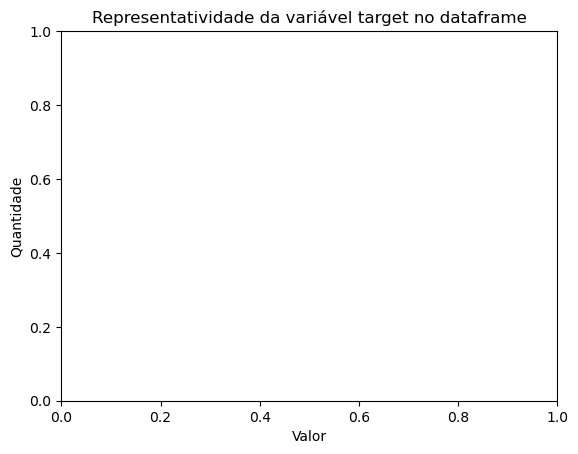

In [9]:
# Check values from database's target 
plt.figure()
plt.title("Representatividade da variável target no dataframe");
plt.xlabel('Valor');
plt.ylabel('Quantidade');

plt.hist(df_final['damaged'].astype(int),bins = 50,color='purple');

# Criando dataframe voltada para 1 sensor

In [4]:
df_ready = defs_.createScaledDataframeScenario(df_final, 1);
n_est = 5000;
optuna_n_trials = 50;
# variation = 'S1';
# columns_drop = [
#     's_sum_'+variation,
#     's_mean_'+variation,
#     's_std_'+variation,
#     'psd_max_'+variation,
#     'psd_sum_'+variation,
#     'f*s_mean_'+variation,
#     'f*s_max_'+variation,
#     'f*s_sum_'+variation,
#     'std_'+variation
#     ]
# df_ready = df_ready.drop(columns=columns_drop);

# Modelo sem Cross validation
### Preparação dos inputs e target
### Setting X and y for model score:0.5545965387932191
# print('Scenario is: ' + str(1))
# Setting target variable
y_new_attemp = df_ready['damaged'];
y_new_attemp = y_new_attemp.astype(int);
# Setting other variables
X_new_attemp = df_ready.drop(columns=['damaged']);
X_new_attemp = X_new_attemp.astype(float);
# Separate database for test and train and 
X_train, X_test, y_train, y_test = train_test_split(X_new_attemp, y_new_attemp, test_size=0.3, shuffle=True);
#Scale df
# std_scaler = StandardScaler()
X_scaled_train = X_train;
X_scaled_test = X_test;
# print('X_scaled_train, y_train e X_scaled_test, y_test estão prontos.')

### Treinando modelo sem otimização
### DEFAULT PARAMETHERS ON FULL DATAFRAME
rf = RandomForestClassifier(n_estimators = n_est);
rf.fit(X_scaled_train,y_train);
### Predict df test
y_pred = rf.predict(X_scaled_test);
accuracy_test = accuracy_score(y_test, y_pred);
print('Preformance de previsão de df de teste Rf(n_esti=5000): ' + "{:.4f}".format(accuracy_test))
### Predict df train (overfit)
y_pred = rf.predict(X_scaled_train);
accuracy_train = accuracy_score(y_train, y_pred);
print('Performance de previsão de df de treino Rf(n_esti=5000): ' + "{:.4f}".format(accuracy_train))
if (accuracy_train > accuracy_test) :
    print('-> overfit(?)')

### Treinando modelo sem otimização
### DEFAULT PARAMETHERS ON FULL DATAFRAME
rf = RandomForestClassifier(n_estimators = n_est);
rf.fit(X_scaled_train,y_train);
### Predict df test
y_pred = rf.predict(X_scaled_test);
accuracy_test = accuracy_score(y_test, y_pred);
print('Preformance de previsão de df de teste Rf(n_esti=10000): ' + "{:.4f}".format(accuracy_test))
### Predict df train (overfit)
y_pred = rf.predict(X_scaled_train);
accuracy_train = accuracy_score(y_train, y_pred);
print('Performance de previsão de df de treino Rf(n_esti=10000): ' + "{:.4f}".format(accuracy_train))
if (accuracy_train > accuracy_test) :
    print('-> overfit(?)')

# Modelo com Cross validation
### Preparação dos inputs e target
### Setting X and y for model
# print('Scenario is: ' + str(1))
# Setting target variable
y_new_attemp = df_ready['damaged'];
y_new_attemp = y_new_attemp.astype(int);
# Setting other variables
X_new_attemp = df_ready.drop(columns=['damaged']);
X_new_attemp = X_new_attemp.astype(float);
#Scale df
std_scaler = StandardScaler()
X_scaled = pd.DataFrame(std_scaler.fit_transform(X_new_attemp), columns=X_new_attemp.columns, index=X_new_attemp.index);
# print('X_scaled_train, y_train e X_scaled_test, y_test estão prontos.')
### DEFAULT PARAMETHERS ON FULL DATAFRAME

score_new_attemp = cross_val_score(RandomForestClassifier(n_estimators = 5000), X_scaled, y_new_attemp);
print('Performance da media das validações cruzadas Rf(n_esti=5000): ' + "{:.4f}".format(np.mean(score_new_attemp)))

score_new_attemp = cross_val_score(RandomForestClassifier(n_estimators = 10000), X_scaled, y_new_attemp);
print('Performance da media das validações cruzadas Rf(n_esti=10000): ' + "{:.4f}".format(np.mean(score_new_attemp)))

Preformance de previsão de df de teste Rf(n_esti=5000): 0.6299
Performance de previsão de df de treino Rf(n_esti=5000): 1.0000
-> overfit(?)
Preformance de previsão de df de teste Rf(n_esti=10000): 0.6364
Performance de previsão de df de treino Rf(n_esti=10000): 1.0000
-> overfit(?)
Performance da media das validações cruzadas Rf(n_esti=5000): 0.6584
Performance da media das validações cruzadas Rf(n_esti=10000): 0.6525


## Create coef models

In [10]:
#PATHS USED
path_quick_test = [
    "./database_raw/DatasetA/zzzAD1.txt",
    "./database_raw/DatasetA/zzzAD30.txt",
    "./database_raw/DatasetA/zzzAD12.txt",
    "./database_raw/DatasetA/zzzAU.txt",
];
std_scaler = StandardScaler()
path = glob.glob("./database_raw/DatasetA/zzzA*.txt", recursive=True);
pathB = glob.glob("./database_raw/DatasetB/zzzB*.txt", recursive=True);

# Qty of row to be aggrouped 
samples = 1024;

df_final = pd.read_csv('df_csv/' + str(samples) + '_samples/dataframe_full', index_col=0, dtype='unicode');
df_labels = defs_.createDatabaseSingleSensor(df_final,1);
qty_features = len(df_labels.columns) - 1;
print('Quantidade de features por sensor: '+ str(qty_features));

df_final

Quantidade de features por sensor: 7


,s_std_S1,psd_max_S1,mean_S1,median_S1,skew_S1,amp_max_min_S1,kurtosis_S1,s_std_S2,psd_max_S2,mean_S2,...,amp_max_min_S29,kurtosis_S29,s_std_S30,psd_max_S30,mean_S30,median_S30,skew_S30,amp_max_min_S30,kurtosis_S30,Scenario
0,0.00036465933472807325,1.4618673162538337e-06,-0.001357755576621094,-0.0022832825,0.01540848754149542,0.9939469999999999,0.10365608906656476,0.00036366823853188954,1.4989815326294138e-06,0.0003729301601596498,...,0.9334039999999999,-0.041878976373719734,0.00036857651984688826,1.3941068882962035e-06,-0.0009625774402050785,-0.00160728,-0.028261960420297376,0.9763257999999999,0.3741716150735144,1
1,0.00042207452952675517,6.920382167677479e-06,-0.00040519520195312557,0.0015726744000000002,-0.03158462525774426,0.9305502,-0.10123098978136014,0.0003950133176255087,7.509789485598451e-06,0.00011308874950195362,...,0.817396,0.22191112206756092,0.0003722529049817076,6.195577443248768e-06,-0.0007408178286132816,0.0031077394999999997,-0.13960095714872756,0.8766658,-0.19597598823181217,1
2,0.00041604672746616624,1.5193793671894531e-05,0.0023152742476074215,0.002926843,-0.003200578863888679,1.3379102999999999,0.4780702410549287,0.000440578205692374,1.6693043753979797e-05,0.0016475376969726568,...,0.9921253,-0.04558174223764322,0.00038442781114097894,1.5196755704974384e-05,-0.0010596247472656256,-0.003839492,0.15268936763001495,0.8964205000000001,0.019830716117583247,1
3,0.0005073348621225908,3.2355832167293724e-05,0.002870112068554689,0.0073151234999999995,0.04559151014305592,1.3072631000000001,-0.3619600938367933,0.0005315861789516026,3.393765760191681e-05,0.002983145234179684,...,1.2732382,-0.060022211791852076,0.00044070784649754966,3.0252831934927443e-05,-0.0006096456118164065,-0.0008257963500000001,-0.03433807485017546,1.0781062000000001,-0.09253528403808797,1
4,0.0004901323388503907,4.779044012798174e-05,0.0012931235627929687,0.0063275250000000005,-0.13343487673558488,1.341857,0.33859537447306876,0.000515600635898816,4.914154095413887e-05,0.0036547457592773437,...,1.1733729,0.21266495365097615,0.0004014585293892493,4.4295721381761545e-05,-0.0008355930417968758,0.005240619,-0.10385369203581078,1.0376701,0.058457058525502426,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7931,0.00046458126034279115,0.12107028456688677,0.00476826078776367,0.002092819,-0.03307297578217123,1.0175052,-0.17276336977073736,0.0004392738303958451,0.12101867764084705,0.0019318421991210918,...,1.0922607,-0.19327809154395847,0.00041029964629942114,0.12101891305769145,0.0022268341846679663,0.004260801,-0.06072306121432907,0.9396711,-0.07285194834540976,0
7932,0.00043057361012635695,0.1219282880533352,0.005682367039843752,0.0048936195,-0.013127725085427092,1.0878601,-0.18480394058884952,0.00041775433839341057,0.12193449799477259,0.002094986317773438,...,1.0383417000000001,0.041516672723074244,0.0003930149163944877,0.12188481440507852,0.0016730884660156261,0.009320239000000001,-0.0628559234161243,1.0328667,0.23811567861600835,0
7933,0.0004405659615977529,0.12292999467066189,0.004501759137304686,0.0007907776000000001,0.12346974947853022,1.348512,0.0690600950416056,0.000447090771859398,0.12292668087547055,0.00016123369628906248,...,1.0282972,-0.1824355834054745,0.0004194833997377595,0.12288674559306505,0.001823433908984375,0.005102217500000001,0.12789408137547786,1.0024451,-0.11665106960237459,0
7934,0.0004507211880661849,0.12409694260774547,0.005475126960449214,0.0024689250000000003,0.070692067618202,1.1554739,0.1045196281269698,0.0004381041541484786,0.12395898547936517,0.0009464561611328124,...,0.9309202999999999,-0.06865255515310409,0.0003938358077485066,0.12384325138224284,0.001275242775927735,-5.1783374999999994e-05,0.02412409924378543,0.8374804,-0.05377166902358077,0


In [11]:
df_ready = defs_.createScaledDataframeScenario(df_final, 1);
df_ready

,s_std_S1,psd_max_S1,mean_S1,median_S1,skew_S1,amp_max_min_S1,kurtosis_S1,damaged
0,0.00036465933472807325,1.4618673162538337e-06,-0.001357755576621094,-0.0022832825,0.01540848754149542,0.9939469999999999,0.10365608906656476,1
1,0.00042207452952675517,6.920382167677479e-06,-0.00040519520195312557,0.0015726744000000002,-0.03158462525774426,0.9305502,-0.10123098978136014,1
2,0.00041604672746616624,1.5193793671894531e-05,0.0023152742476074215,0.002926843,-0.003200578863888679,1.3379102999999999,0.4780702410549287,1
3,0.0005073348621225908,3.2355832167293724e-05,0.002870112068554689,0.0073151234999999995,0.04559151014305592,1.3072631000000001,-0.3619600938367933,1
4,0.0004901323388503907,4.779044012798174e-05,0.0012931235627929687,0.0063275250000000005,-0.13343487673558488,1.341857,0.33859537447306876,1
...,...,...,...,...,...,...,...,...
507,0.0004311942799256529,0.0190256964385078,-0.0035177598002929652,-0.002066027,0.029629686570482962,1.1098325999999998,-0.09416570659190748,0
508,0.00041119097797443676,0.10339176738310737,-0.0017789671304296864,0.006683234,-0.09260364721727211,1.0747536,-0.17256514264052258,0
509,0.0004226882568152164,0.047591506910561084,0.005126196698828122,0.00051439195,0.04220596633344893,1.0402923,-0.09530550727710141,0
510,0.0004187281546688843,0.04064098005375383,-0.0003749743759765631,-0.00110682275,0.04513323827709041,1.0633537,0.03212862268004546,0


In [12]:
### OPTMAZING PARAMETHERS TO MAXIMIZE SCORE ON QUICK DATAFRAME {'n_estimators': 800, 'max_depth': 2}
### last score: 0.5761515497421756

def objective(trial):
    ### PARAMS
    # param_n_estimators = trial.suggest_int('n_estimators',100,100000,100);
    param_max_features = trial.suggest_int('max_features',1,qty_features,1);
    param_max_depth = trial.suggest_int('max_depth',1,50,1);
    # param_min_samples_split = trial.suggest_int('min_samples_split',1,20,1);

    rf_com_cross_optuna = RandomForestClassifier(n_estimators = n_est, bootstrap=True, max_samples=0.8, max_features=param_max_features, max_depth=param_max_depth);
    score_new_attemp = cross_val_score(rf_com_cross_optuna, X_new_attemp, y_new_attemp);

    return np.mean(score_new_attemp)

In [16]:
n_est = 500;
optuna_n_trials = 50;
head_columns = [
    'Sensor',
    'acc_cross',
    'std_acc',
    'acc_sem',
    'pod',
    'param',
    'acc_com_cross_optuna',
    'std_acc_otm',
    'acc_sem_cross_optuna',
    'pod_optuna',
];
grouped_values = pd.DataFrame(columns=head_columns);

for path_new in tqdm(path):
    scenario = defs_.getDamageScenarioLabel(path_new);
    df_ready = defs_.createScaledDataframeScenario(df_final, scenario);
    new_row = [];
    new_row.append('S' + str(scenario));
    print('Sensor: S' + str(scenario) + ' and Scenario: ' + str(scenario));
    
    if scenario == 0:
        break
    
    ### Setting X and y for model score
    # Setting target variable
    y_new_attemp = df_ready['damaged'];
    y_new_attemp = y_new_attemp.astype(int);
    # Setting other variables
    X_new_attemp = df_ready.drop(columns=['damaged']);
    X_new_attemp = X_new_attemp.astype(float);
    
    X_scaled_new_attemp = pd.DataFrame(std_scaler.fit_transform(X_new_attemp), columns=X_new_attemp.columns, index=X_new_attemp.index)

    ### Modelo com Cross validation 
    rf_com_cross = RandomForestClassifier(n_estimators = n_est);
    score_new_attemp = cross_val_score(rf_com_cross, X_scaled_new_attemp, y_new_attemp);
    new_row.append("{:.4f}".format(np.mean(score_new_attemp)));
    print('Performance da media das validações cruzadas: ' + "{:.4f}".format(np.mean(score_new_attemp)))
    new_row.append("{:.4f}".format(np.std(score_new_attemp)));
    print('Desvio padrão das validações cruzadas: ' + "{:.4f}".format(np.std(score_new_attemp)))

    # Modelo sem Cross validation 
    X_train, X_test, y_train, y_test = train_test_split(X_new_attemp, y_new_attemp, test_size=0.3, shuffle=True);

    X_scaled_train = pd.DataFrame(std_scaler.fit_transform(X_train), columns=X_train.columns, index=X_train.index);
    X_scaled_test = pd.DataFrame(std_scaler.fit_transform(X_test), columns=X_test.columns, index=X_test.index);

    X_train_sem_cross = X_scaled_train;
    X_test_sem_cross = X_scaled_test;
    y_train_sem_cross = y_train;
    y_test_sem_cross = y_test;
    ### DEFAULT PARAMETHERS ON FULL DATAFRAME
    rf_sem_cross = RandomForestClassifier(n_estimators = n_est);
    rf_sem_cross.fit(X_train_sem_cross,y_train_sem_cross);
    ### Predict df test
    y_pred = rf_sem_cross.predict(X_test_sem_cross);
    accuracy_test = accuracy_score(y_test_sem_cross, y_pred);
    print('Preformance de previsão de df de teste: ' + "{:.4f}".format(accuracy_test));
    new_row.append("{:.4f}".format(accuracy_test));
    ## Predict df train (overfit)
    y_pred_overfit = rf_sem_cross.predict(X_train_sem_cross);
    accuracy_train = accuracy_score(y_train_sem_cross, y_pred_overfit);
    print('-> overfit(?): ' + "{:.4f}".format(accuracy_train));

    #PATHB
    for path_b in pathB:
        index = defs_.getDamageScenarioLabel(path_b);
        if ( index == scenario):
            path_used = path_b;
            break
       
    df_scenario = defs_.createDatabase(path_used);
    df_scenario = df_scenario.astype(float);
    # [index,    'Time',      'S1'  , ..., 'Scenario']
    # [  0,     0.000000,   0.004954, ...,     1.0   ]
    # [ ...,       ...,        ...  , ...,     ...   ]
    # [ 262k,   255.9999,  -0.211089, ...,     1.0   ]
    sensor = 3;
    sensor_label = 'S'+ str(scenario);
    df_scenario_S1 = defs_.getStatisticalCaracteristics(df_scenario, sensor_label, qty_group=samples, typeof='both');
    df_scenario_S1 = df_scenario_S1.astype(float);

    ### Predict df test
    y_pred = rf_sem_cross.predict(df_scenario_S1);
    new_row.append("{:.4f}".format(defs_.probabilityOfDamage(y_pred)));
    print('Probability of damage: ' + "{:.4f}".format(defs_.probabilityOfDamage(y_pred)));
    
    study = optuna.create_study(direction='maximize');
    study.optimize(objective, n_trials=optuna_n_trials);
    new_row.append(study.best_params);
    print(study.best_params);

    ### Modelo com Cross validation e 
    rf_com_cross = RandomForestClassifier(n_estimators = n_est, bootstrap=True, max_samples=0.8, max_features= study.best_params['max_features'], max_depth= study.best_params['max_depth']);
    score_new_attemp = cross_val_score(rf_com_cross, X_new_attemp, y_new_attemp);
    new_row.append("{:.4f}".format(np.mean(score_new_attemp)));
    print('Performance da media das validações cruzadas: ' + "{:.4f}".format(np.mean(score_new_attemp)))
    new_row.append("{:.4f}".format(np.std(score_new_attemp)));
    print('Desvio padrão das validações cruzadas: ' + "{:.4f}".format(np.std(score_new_attemp)))

    ### Modelo com optuna sem Cross validation
    rf_sem_cross = RandomForestClassifier(n_estimators = n_est, bootstrap=True, max_samples=0.8,max_features= study.best_params['max_features'], max_depth= study.best_params['max_depth']);
    rf_sem_cross.fit(X_train_sem_cross,y_train_sem_cross);
    ### Predict df test
    y_pred = rf_sem_cross.predict(X_test_sem_cross);
    accuracy_test = accuracy_score(y_test_sem_cross, y_pred);
    print('Preformance de previsão de df de teste: ' + "{:.4f}".format(accuracy_test));
    new_row.append("{:.4f}".format(accuracy_test));
    ## Predict df train (overfit)
    y_pred_overfit = rf_sem_cross.predict(X_train_sem_cross);
    accuracy_train = accuracy_score(y_train_sem_cross, y_pred_overfit);
    print('-> overfit(?): ' + "{:.4f}".format(accuracy_train));

    ### Predict df test
    y_pred = rf_sem_cross.predict(df_scenario_S1);
    new_row.append("{:.4f}".format(defs_.probabilityOfDamage(y_pred)));
    print('Probability of damage: ' + "{:.4f}".format(defs_.probabilityOfDamage(y_pred)));
    
    array_features = pd.DataFrame([new_row], columns=grouped_values.columns);
    grouped_values = pd.concat([grouped_values, array_features], ignore_index=True);

# time: 1h 16m 6s
grouped_values

  0%|          | 0/31 [00:00<?, ?it/s]

Sensor: S1 and Scenario: 1
Performance da media das validações cruzadas: 0.3811
Desvio padrão das validações cruzadas: 0.1193
Preformance de previsão de df de teste: 0.6494
-> overfit(?): 1.0000


[I 2023-06-29 14:50:16,795] A new study created in memory with name: no-name-4c939831-ee55-42b7-be7e-7ec3d9d95884


Probability of damage: 1.0000


[I 2023-06-29 14:50:19,324] Trial 0 finished with value: 0.38688368551304014 and parameters: {'max_features': 4, 'max_depth': 8}. Best is trial 0 with value: 0.38688368551304014.
[I 2023-06-29 14:50:22,490] Trial 1 finished with value: 0.38100133257186375 and parameters: {'max_features': 5, 'max_depth': 39}. Best is trial 0 with value: 0.38688368551304014.
[I 2023-06-29 14:50:25,733] Trial 2 finished with value: 0.3712735579668761 and parameters: {'max_features': 6, 'max_depth': 35}. Best is trial 0 with value: 0.38688368551304014.
[I 2023-06-29 14:50:28,378] Trial 3 finished with value: 0.38890158004949554 and parameters: {'max_features': 3, 'max_depth': 34}. Best is trial 3 with value: 0.38890158004949554.
[I 2023-06-29 14:50:30,576] Trial 4 finished with value: 0.3811345897582334 and parameters: {'max_features': 1, 'max_depth': 46}. Best is trial 3 with value: 0.38890158004949554.
[I 2023-06-29 14:50:33,916] Trial 5 finished with value: 0.3635065676756139 and parameters: {'max_featu

{'max_features': 2, 'max_depth': 1}
Performance da media das validações cruzadas: 0.4730
Desvio padrão das validações cruzadas: 0.1923
Preformance de previsão de df de teste: 0.6299
-> overfit(?): 0.6899
Probability of damage: 1.0000
Sensor: S10 and Scenario: 10
Performance da media das validações cruzadas: 0.3558
Desvio padrão das validações cruzadas: 0.0647
Preformance de previsão de df de teste: 0.6364
-> overfit(?): 1.0000


[I 2023-06-29 14:52:22,796] A new study created in memory with name: no-name-4bd822c4-67bd-4389-ad11-a961063bd546


Probability of damage: 0.4727


[I 2023-06-29 14:52:25,762] Trial 0 finished with value: 0.38313344755377876 and parameters: {'max_features': 6, 'max_depth': 32}. Best is trial 0 with value: 0.38313344755377876.
[I 2023-06-29 14:52:27,977] Trial 1 finished with value: 0.3655054254711593 and parameters: {'max_features': 2, 'max_depth': 17}. Best is trial 0 with value: 0.38313344755377876.
[I 2023-06-29 14:52:30,836] Trial 2 finished with value: 0.36744717304397484 and parameters: {'max_features': 6, 'max_depth': 9}. Best is trial 0 with value: 0.38313344755377876.
[I 2023-06-29 14:52:33,059] Trial 3 finished with value: 0.36360175138016365 and parameters: {'max_features': 2, 'max_depth': 39}. Best is trial 0 with value: 0.38313344755377876.
[I 2023-06-29 14:52:35,838] Trial 4 finished with value: 0.3772701313535123 and parameters: {'max_features': 5, 'max_depth': 40}. Best is trial 0 with value: 0.38313344755377876.
[I 2023-06-29 14:52:38,962] Trial 5 finished with value: 0.38509423186750424 and parameters: {'max_feat

{'max_features': 3, 'max_depth': 1}
Performance da media das validações cruzadas: 0.4378
Desvio padrão das validações cruzadas: 0.1915
Preformance de previsão de df de teste: 0.6234
-> overfit(?): 0.6341
Probability of damage: 1.0000
Sensor: S11 and Scenario: 11
Performance da media das validações cruzadas: 0.3478
Desvio padrão das validações cruzadas: 0.0364
Preformance de previsão de df de teste: 0.5974
-> overfit(?): 1.0000


[I 2023-06-29 14:54:28,573] A new study created in memory with name: no-name-e6a7c7aa-22be-41f8-b342-b30eaac71caa


Probability of damage: 0.3789


[I 2023-06-29 14:54:30,975] Trial 0 finished with value: 0.3340757662288216 and parameters: {'max_features': 3, 'max_depth': 14}. Best is trial 0 with value: 0.3340757662288216.
[I 2023-06-29 14:54:33,026] Trial 1 finished with value: 0.36150770988006853 and parameters: {'max_features': 1, 'max_depth': 44}. Best is trial 1 with value: 0.36150770988006853.
[I 2023-06-29 14:54:35,214] Trial 2 finished with value: 0.3498191509613554 and parameters: {'max_features': 2, 'max_depth': 10}. Best is trial 1 with value: 0.36150770988006853.
[I 2023-06-29 14:54:37,618] Trial 3 finished with value: 0.332172092137826 and parameters: {'max_features': 3, 'max_depth': 11}. Best is trial 1 with value: 0.36150770988006853.
[I 2023-06-29 14:54:40,228] Trial 4 finished with value: 0.33211498191509614 and parameters: {'max_features': 4, 'max_depth': 41}. Best is trial 1 with value: 0.36150770988006853.
[I 2023-06-29 14:54:42,873] Trial 5 finished with value: 0.33019227108319055 and parameters: {'max_featur

{'max_features': 1, 'max_depth': 36}
Performance da media das validações cruzadas: 0.3713
Desvio padrão das validações cruzadas: 0.0577
Preformance de previsão de df de teste: 0.5844
-> overfit(?): 1.0000
Probability of damage: 0.9688
Sensor: S12 and Scenario: 12
Performance da media das validações cruzadas: 0.4239
Desvio padrão das validações cruzadas: 0.0675
Preformance de previsão de df de teste: 0.6429
-> overfit(?): 1.0000


[I 2023-06-29 14:56:30,724] A new study created in memory with name: no-name-1b26b899-9c7f-4e8f-8ffc-d94e3e9431a6


Probability of damage: 0.9961


[I 2023-06-29 14:56:33,276] Trial 0 finished with value: 0.43556063201979817 and parameters: {'max_features': 4, 'max_depth': 23}. Best is trial 0 with value: 0.43556063201979817.
[I 2023-06-29 14:56:36,352] Trial 1 finished with value: 0.44338473253379024 and parameters: {'max_features': 7, 'max_depth': 27}. Best is trial 1 with value: 0.44338473253379024.
[I 2023-06-29 14:56:38,381] Trial 2 finished with value: 0.4376546735198934 and parameters: {'max_features': 1, 'max_depth': 48}. Best is trial 1 with value: 0.44338473253379024.
[I 2023-06-29 14:56:41,461] Trial 3 finished with value: 0.4453264801066058 and parameters: {'max_features': 7, 'max_depth': 20}. Best is trial 3 with value: 0.4453264801066058.
[I 2023-06-29 14:56:43,460] Trial 4 finished with value: 0.49434608794974305 and parameters: {'max_features': 5, 'max_depth': 2}. Best is trial 4 with value: 0.49434608794974305.
[I 2023-06-29 14:56:46,520] Trial 5 finished with value: 0.44924804873405677 and parameters: {'max_featu

{'max_features': 5, 'max_depth': 2}
Performance da media das validações cruzadas: 0.4886
Desvio padrão das validações cruzadas: 0.1102
Preformance de previsão de df de teste: 0.6429
-> overfit(?): 0.7263
Probability of damage: 0.9688
Sensor: S13 and Scenario: 13
Performance da media das validações cruzadas: 0.4438
Desvio padrão das validações cruzadas: 0.1269
Preformance de previsão de df de teste: 0.7273
-> overfit(?): 1.0000


[I 2023-06-29 14:58:43,473] A new study created in memory with name: no-name-290a5f6f-332f-47ca-9e9c-b740d948367f


Probability of damage: 0.0000


[I 2023-06-29 14:58:46,238] Trial 0 finished with value: 0.46919855320769077 and parameters: {'max_features': 5, 'max_depth': 46}. Best is trial 0 with value: 0.46919855320769077.
[I 2023-06-29 14:58:48,955] Trial 1 finished with value: 0.47308204835332185 and parameters: {'max_features': 5, 'max_depth': 38}. Best is trial 1 with value: 0.47308204835332185.
[I 2023-06-29 14:58:52,054] Trial 2 finished with value: 0.46135541595278884 and parameters: {'max_features': 7, 'max_depth': 18}. Best is trial 1 with value: 0.47308204835332185.
[I 2023-06-29 14:58:55,011] Trial 3 finished with value: 0.46725680563487526 and parameters: {'max_features': 6, 'max_depth': 19}. Best is trial 1 with value: 0.47308204835332185.
[I 2023-06-29 14:58:57,901] Trial 4 finished with value: 0.4554730630116124 and parameters: {'max_features': 6, 'max_depth': 30}. Best is trial 1 with value: 0.47308204835332185.
[I 2023-06-29 14:59:00,041] Trial 5 finished with value: 0.4379592613744527 and parameters: {'max_fea

{'max_features': 5, 'max_depth': 3}
Performance da media das validações cruzadas: 0.4906
Desvio padrão das validações cruzadas: 0.1266
Preformance de previsão de df de teste: 0.7078
-> overfit(?): 0.8101
Probability of damage: 0.0000
Sensor: S14 and Scenario: 14
Performance da media das validações cruzadas: 0.4810
Desvio padrão das validações cruzadas: 0.1558
Preformance de previsão de df de teste: 0.7013
-> overfit(?): 1.0000


[I 2023-06-29 15:01:08,107] A new study created in memory with name: no-name-def5f74f-6dce-4d29-a8df-d539ac463116


Probability of damage: 0.0000


[I 2023-06-29 15:01:11,060] Trial 0 finished with value: 0.44951456310679616 and parameters: {'max_features': 7, 'max_depth': 43}. Best is trial 0 with value: 0.44951456310679616.
[I 2023-06-29 15:01:13,045] Trial 1 finished with value: 0.48103940605368356 and parameters: {'max_features': 1, 'max_depth': 45}. Best is trial 1 with value: 0.48103940605368356.
[I 2023-06-29 15:01:15,031] Trial 2 finished with value: 0.5045307443365695 and parameters: {'max_features': 1, 'max_depth': 36}. Best is trial 2 with value: 0.5045307443365695.
[I 2023-06-29 15:01:17,335] Trial 3 finished with value: 0.47506186940795736 and parameters: {'max_features': 3, 'max_depth': 20}. Best is trial 2 with value: 0.5045307443365695.
[I 2023-06-29 15:01:20,066] Trial 4 finished with value: 0.45345516847515704 and parameters: {'max_features': 6, 'max_depth': 14}. Best is trial 2 with value: 0.5045307443365695.
[I 2023-06-29 15:01:22,361] Trial 5 finished with value: 0.4672187321530553 and parameters: {'max_featur

{'max_features': 5, 'max_depth': 1}
Performance da media das validações cruzadas: 0.6586
Desvio padrão das validações cruzadas: 0.1627
Preformance de previsão de df de teste: 0.7338
-> overfit(?): 0.6872
Probability of damage: 0.0000
Sensor: S15 and Scenario: 15
Performance da media das validações cruzadas: 0.3709
Desvio padrão das validações cruzadas: 0.1181
Preformance de previsão de df de teste: 0.6818
-> overfit(?): 1.0000


[I 2023-06-29 15:03:09,565] A new study created in memory with name: no-name-464cda4d-c574-4d88-9bd3-491975235cb1


Probability of damage: 0.3867


[I 2023-06-29 15:03:12,702] Trial 0 finished with value: 0.38062059775366464 and parameters: {'max_features': 7, 'max_depth': 44}. Best is trial 0 with value: 0.38062059775366464.
[I 2023-06-29 15:03:15,255] Trial 1 finished with value: 0.3688749286122216 and parameters: {'max_features': 4, 'max_depth': 43}. Best is trial 0 with value: 0.38062059775366464.
[I 2023-06-29 15:03:17,475] Trial 2 finished with value: 0.36895107557586143 and parameters: {'max_features': 2, 'max_depth': 49}. Best is trial 0 with value: 0.38062059775366464.
[I 2023-06-29 15:03:20,603] Trial 3 finished with value: 0.38648391395393106 and parameters: {'max_features': 7, 'max_depth': 15}. Best is trial 3 with value: 0.38648391395393106.
[I 2023-06-29 15:03:22,613] Trial 4 finished with value: 0.3787740338853988 and parameters: {'max_features': 1, 'max_depth': 11}. Best is trial 3 with value: 0.38648391395393106.
[I 2023-06-29 15:03:25,011] Trial 5 finished with value: 0.3728155339805826 and parameters: {'max_feat

{'max_features': 6, 'max_depth': 21}
Performance da media das validações cruzadas: 0.3767
Desvio padrão das validações cruzadas: 0.1111
Preformance de previsão de df de teste: 0.7208
-> overfit(?): 1.0000
Probability of damage: 0.2891
Sensor: S16 and Scenario: 16
Performance da media das validações cruzadas: 0.5198
Desvio padrão das validações cruzadas: 0.1406
Preformance de previsão de df de teste: 0.6688
-> overfit(?): 1.0000


[I 2023-06-29 15:05:38,349] A new study created in memory with name: no-name-c9582a2b-2f6e-41b0-a541-257e8b585716


Probability of damage: 1.0000


[I 2023-06-29 15:05:40,842] Trial 0 finished with value: 0.533447553778793 and parameters: {'max_features': 4, 'max_depth': 39}. Best is trial 0 with value: 0.533447553778793.
[I 2023-06-29 15:05:43,818] Trial 1 finished with value: 0.513877784123358 and parameters: {'max_features': 7, 'max_depth': 38}. Best is trial 0 with value: 0.533447553778793.
[I 2023-06-29 15:05:46,459] Trial 2 finished with value: 0.5334094802969731 and parameters: {'max_features': 5, 'max_depth': 14}. Best is trial 0 with value: 0.533447553778793.
[I 2023-06-29 15:05:48,786] Trial 3 finished with value: 0.5392918332381497 and parameters: {'max_features': 3, 'max_depth': 47}. Best is trial 3 with value: 0.5392918332381497.
[I 2023-06-29 15:05:51,425] Trial 4 finished with value: 0.5295640586331619 and parameters: {'max_features': 5, 'max_depth': 22}. Best is trial 3 with value: 0.5392918332381497.
[I 2023-06-29 15:05:54,173] Trial 5 finished with value: 0.5236817056919856 and parameters: {'max_features': 6, 'ma

{'max_features': 6, 'max_depth': 1}
Performance da media das validações cruzadas: 0.6270
Desvio padrão das validações cruzadas: 0.0593
Preformance de previsão de df de teste: 0.6558
-> overfit(?): 0.7291
Probability of damage: 1.0000
Sensor: S17 and Scenario: 17
Performance da media das validações cruzadas: 0.5254
Desvio padrão das validações cruzadas: 0.1454
Preformance de previsão de df de teste: 0.8117
-> overfit(?): 1.0000


[I 2023-06-29 15:07:43,904] A new study created in memory with name: no-name-3baa656a-9325-4b8e-9887-7114380efd11


Probability of damage: 0.0000


[I 2023-06-29 15:07:46,322] Trial 0 finished with value: 0.503883495145631 and parameters: {'max_features': 4, 'max_depth': 48}. Best is trial 0 with value: 0.503883495145631.
[I 2023-06-29 15:07:48,754] Trial 1 finished with value: 0.5136683799733486 and parameters: {'max_features': 4, 'max_depth': 32}. Best is trial 1 with value: 0.5136683799733486.
[I 2023-06-29 15:07:51,455] Trial 2 finished with value: 0.5058062059775367 and parameters: {'max_features': 6, 'max_depth': 9}. Best is trial 1 with value: 0.5136683799733486.
[I 2023-06-29 15:07:54,356] Trial 3 finished with value: 0.4940986103179135 and parameters: {'max_features': 7, 'max_depth': 50}. Best is trial 1 with value: 0.5136683799733486.
[I 2023-06-29 15:07:56,320] Trial 4 finished with value: 0.5606320197982105 and parameters: {'max_features': 1, 'max_depth': 45}. Best is trial 4 with value: 0.5606320197982105.
[I 2023-06-29 15:07:58,921] Trial 5 finished with value: 0.5019036740909956 and parameters: {'max_features': 5, '

{'max_features': 7, 'max_depth': 1}
Performance da media das validações cruzadas: 0.8044
Desvio padrão das validações cruzadas: 0.0852
Preformance de previsão de df de teste: 0.8442
-> overfit(?): 0.8017
Probability of damage: 0.0000
Sensor: S18 and Scenario: 18
Performance da media das validações cruzadas: 0.7306
Desvio padrão das validações cruzadas: 0.1122
Preformance de previsão de df de teste: 0.9091
-> overfit(?): 1.0000


[I 2023-06-29 15:09:53,548] A new study created in memory with name: no-name-f008d273-7e4f-44ed-a0ca-8505d1e1be1b


Probability of damage: 0.0000


[I 2023-06-29 15:09:55,763] Trial 0 finished with value: 0.736493432324386 and parameters: {'max_features': 3, 'max_depth': 19}. Best is trial 0 with value: 0.736493432324386.
[I 2023-06-29 15:09:57,811] Trial 1 finished with value: 0.7364363221016561 and parameters: {'max_features': 2, 'max_depth': 35}. Best is trial 0 with value: 0.736493432324386.
[I 2023-06-29 15:09:59,755] Trial 2 finished with value: 0.7324957167332952 and parameters: {'max_features': 1, 'max_depth': 16}. Best is trial 0 with value: 0.736493432324386.
[I 2023-06-29 15:10:02,201] Trial 3 finished with value: 0.7463163906339234 and parameters: {'max_features': 5, 'max_depth': 25}. Best is trial 3 with value: 0.7463163906339234.
[I 2023-06-29 15:10:04,516] Trial 4 finished with value: 0.7482962116885589 and parameters: {'max_features': 4, 'max_depth': 18}. Best is trial 4 with value: 0.7482962116885589.
[I 2023-06-29 15:10:06,708] Trial 5 finished with value: 0.740376927470017 and parameters: {'max_features': 3, 'ma

{'max_features': 5, 'max_depth': 1}
Performance da media das validações cruzadas: 0.8375
Desvio padrão das validações cruzadas: 0.0885
Preformance de previsão de df de teste: 0.8831
-> overfit(?): 0.8464
Probability of damage: 0.0000
Sensor: S19 and Scenario: 19
Performance da media das validações cruzadas: 0.3924
Desvio padrão das validações cruzadas: 0.0997
Preformance de previsão de df de teste: 0.6429
-> overfit(?): 1.0000


[I 2023-06-29 15:11:58,495] A new study created in memory with name: no-name-76656aea-4922-41f5-819f-6120f0ae65d2


Probability of damage: 0.0078


[I 2023-06-29 15:12:01,587] Trial 0 finished with value: 0.3983818770226537 and parameters: {'max_features': 7, 'max_depth': 10}. Best is trial 0 with value: 0.3983818770226537.
[I 2023-06-29 15:12:04,291] Trial 1 finished with value: 0.3827717494764896 and parameters: {'max_features': 5, 'max_depth': 9}. Best is trial 0 with value: 0.3983818770226537.
[I 2023-06-29 15:12:06,307] Trial 2 finished with value: 0.396516276413478 and parameters: {'max_features': 1, 'max_depth': 18}. Best is trial 0 with value: 0.3983818770226537.
[I 2023-06-29 15:12:08,543] Trial 3 finished with value: 0.3789263278126785 and parameters: {'max_features': 3, 'max_depth': 7}. Best is trial 0 with value: 0.3983818770226537.
[I 2023-06-29 15:12:11,357] Trial 4 finished with value: 0.39836284028174374 and parameters: {'max_features': 5, 'max_depth': 28}. Best is trial 0 with value: 0.3983818770226537.
[I 2023-06-29 15:12:13,677] Trial 5 finished with value: 0.34976204073862555 and parameters: {'max_features': 7,

{'max_features': 4, 'max_depth': 42}
Performance da media das validações cruzadas: 0.3945
Desvio padrão das validações cruzadas: 0.0838
Preformance de previsão de df de teste: 0.6169
-> overfit(?): 1.0000
Probability of damage: 0.0273
Sensor: S2 and Scenario: 2
Performance da media das validações cruzadas: 0.4022
Desvio padrão das validações cruzadas: 0.0807
Preformance de previsão de df de teste: 0.6234
-> overfit(?): 1.0000


[I 2023-06-29 15:14:20,320] A new study created in memory with name: no-name-4951d74d-9b58-4daf-8087-965c0e67878a


Probability of damage: 0.0000


[I 2023-06-29 15:14:22,312] Trial 0 finished with value: 0.4511517228250524 and parameters: {'max_features': 3, 'max_depth': 3}. Best is trial 0 with value: 0.4511517228250524.
[I 2023-06-29 15:14:24,332] Trial 1 finished with value: 0.41399200456881785 and parameters: {'max_features': 1, 'max_depth': 42}. Best is trial 0 with value: 0.4511517228250524.
[I 2023-06-29 15:14:26,330] Trial 2 finished with value: 0.410032362459547 and parameters: {'max_features': 1, 'max_depth': 34}. Best is trial 0 with value: 0.4511517228250524.
[I 2023-06-29 15:14:28,994] Trial 3 finished with value: 0.38646487721302114 and parameters: {'max_features': 5, 'max_depth': 42}. Best is trial 0 with value: 0.4511517228250524.
[I 2023-06-29 15:14:30,993] Trial 4 finished with value: 0.41395393108699796 and parameters: {'max_features': 1, 'max_depth': 24}. Best is trial 0 with value: 0.4511517228250524.
[I 2023-06-29 15:14:33,362] Trial 5 finished with value: 0.39042451932229205 and parameters: {'max_features':

{'max_features': 2, 'max_depth': 1}
Performance da media das validações cruzadas: 0.4786
Desvio padrão das validações cruzadas: 0.1258
Preformance de previsão de df de teste: 0.5714
-> overfit(?): 0.6676
Probability of damage: 0.9648
Sensor: S20 and Scenario: 20
Performance da media das validações cruzadas: 0.3690
Desvio padrão das validações cruzadas: 0.0517
Preformance de previsão de df de teste: 0.6948
-> overfit(?): 1.0000


[I 2023-06-29 15:16:18,668] A new study created in memory with name: no-name-688f1440-c9bc-4fb1-b9b6-b19ac003512b


Probability of damage: 1.0000


[I 2023-06-29 15:16:21,629] Trial 0 finished with value: 0.3650485436893204 and parameters: {'max_features': 6, 'max_depth': 21}. Best is trial 0 with value: 0.3650485436893204.
[I 2023-06-29 15:16:24,755] Trial 1 finished with value: 0.3592042642299638 and parameters: {'max_features': 7, 'max_depth': 20}. Best is trial 0 with value: 0.3650485436893204.
[I 2023-06-29 15:16:27,152] Trial 2 finished with value: 0.363068722634685 and parameters: {'max_features': 3, 'max_depth': 43}. Best is trial 0 with value: 0.3650485436893204.
[I 2023-06-29 15:16:30,269] Trial 3 finished with value: 0.3709118598895869 and parameters: {'max_features': 7, 'max_depth': 49}. Best is trial 3 with value: 0.3709118598895869.
[I 2023-06-29 15:16:33,428] Trial 4 finished with value: 0.363068722634685 and parameters: {'max_features': 7, 'max_depth': 18}. Best is trial 3 with value: 0.3709118598895869.
[I 2023-06-29 15:16:36,212] Trial 5 finished with value: 0.36699029126213595 and parameters: {'max_features': 5,

{'max_features': 2, 'max_depth': 1}
Performance da media das validações cruzadas: 0.4412
Desvio padrão das validações cruzadas: 0.1241
Preformance de previsão de df de teste: 0.6429
-> overfit(?): 0.6676
Probability of damage: 1.0000
Sensor: S21 and Scenario: 21
Performance da media das validações cruzadas: 0.4045
Desvio padrão das validações cruzadas: 0.0906
Preformance de previsão de df de teste: 0.6883
-> overfit(?): 1.0000


[I 2023-06-29 15:18:19,132] A new study created in memory with name: no-name-ad114faa-4f64-4ca5-97d6-b6468b983e5a


Probability of damage: 0.0000


[I 2023-06-29 15:18:22,231] Trial 0 finished with value: 0.41798972015990865 and parameters: {'max_features': 7, 'max_depth': 26}. Best is trial 0 with value: 0.41798972015990865.
[I 2023-06-29 15:18:25,062] Trial 1 finished with value: 0.4160479725870931 and parameters: {'max_features': 6, 'max_depth': 10}. Best is trial 0 with value: 0.41798972015990865.
[I 2023-06-29 15:18:27,785] Trial 2 finished with value: 0.4083000190367409 and parameters: {'max_features': 5, 'max_depth': 38}. Best is trial 0 with value: 0.41798972015990865.
[I 2023-06-29 15:18:29,821] Trial 3 finished with value: 0.4220255092328194 and parameters: {'max_features': 1, 'max_depth': 19}. Best is trial 3 with value: 0.4220255092328194.
[I 2023-06-29 15:18:32,954] Trial 4 finished with value: 0.41024176660955647 and parameters: {'max_features': 7, 'max_depth': 37}. Best is trial 3 with value: 0.4220255092328194.
[I 2023-06-29 15:18:35,385] Trial 5 finished with value: 0.4102988768322863 and parameters: {'max_feature

{'max_features': 4, 'max_depth': 1}
Performance da media das validações cruzadas: 0.5157
Desvio padrão das validações cruzadas: 0.1631
Preformance de previsão de df de teste: 0.6169
-> overfit(?): 0.6732
Probability of damage: 1.0000
Sensor: S22 and Scenario: 22
Performance da media das validações cruzadas: 0.4962
Desvio padrão das validações cruzadas: 0.0938
Preformance de previsão de df de teste: 0.6688
-> overfit(?): 1.0000


[I 2023-06-29 15:20:25,445] A new study created in memory with name: no-name-0fd827e0-1cd7-48c8-b521-217088484245


Probability of damage: 0.0000


[I 2023-06-29 15:20:28,456] Trial 0 finished with value: 0.4903864458404722 and parameters: {'max_features': 7, 'max_depth': 25}. Best is trial 0 with value: 0.4903864458404722.
[I 2023-06-29 15:20:30,664] Trial 1 finished with value: 0.48446601941747575 and parameters: {'max_features': 2, 'max_depth': 26}. Best is trial 0 with value: 0.4903864458404722.
[I 2023-06-29 15:20:33,662] Trial 2 finished with value: 0.49624976204073856 and parameters: {'max_features': 7, 'max_depth': 48}. Best is trial 2 with value: 0.49624976204073856.
[I 2023-06-29 15:20:35,586] Trial 3 finished with value: 0.486521987435751 and parameters: {'max_features': 2, 'max_depth': 4}. Best is trial 2 with value: 0.49624976204073856.
[I 2023-06-29 15:20:38,220] Trial 4 finished with value: 0.5118027793641728 and parameters: {'max_features': 5, 'max_depth': 31}. Best is trial 4 with value: 0.5118027793641728.
[I 2023-06-29 15:20:40,870] Trial 5 finished with value: 0.5039977155910909 and parameters: {'max_features':

{'max_features': 4, 'max_depth': 36}
Performance da media das validações cruzadas: 0.5021
Desvio padrão das validações cruzadas: 0.0813
Preformance de previsão de df de teste: 0.6623
-> overfit(?): 1.0000
Probability of damage: 0.0000
Sensor: S23 and Scenario: 23
Performance da media das validações cruzadas: 0.4452
Desvio padrão das validações cruzadas: 0.0945
Preformance de previsão de df de teste: 0.7078
-> overfit(?): 1.0000


[I 2023-06-29 15:22:44,715] A new study created in memory with name: no-name-4aff3336-06b4-437e-9866-b8ec85713ae3


Probability of damage: 0.0000


[I 2023-06-29 15:22:47,594] Trial 0 finished with value: 0.4646487721302113 and parameters: {'max_features': 6, 'max_depth': 16}. Best is trial 0 with value: 0.4646487721302113.
[I 2023-06-29 15:22:50,298] Trial 1 finished with value: 0.46078431372549017 and parameters: {'max_features': 5, 'max_depth': 38}. Best is trial 0 with value: 0.4646487721302113.
[I 2023-06-29 15:22:52,839] Trial 2 finished with value: 0.45105653912050253 and parameters: {'max_features': 4, 'max_depth': 13}. Best is trial 0 with value: 0.4646487721302113.
[I 2023-06-29 15:22:55,221] Trial 3 finished with value: 0.4549590710070436 and parameters: {'max_features': 3, 'max_depth': 37}. Best is trial 0 with value: 0.4646487721302113.
[I 2023-06-29 15:22:57,381] Trial 4 finished with value: 0.4412716542927851 and parameters: {'max_features': 2, 'max_depth': 10}. Best is trial 0 with value: 0.4646487721302113.
[I 2023-06-29 15:23:00,493] Trial 5 finished with value: 0.4588044926708547 and parameters: {'max_features':

{'max_features': 6, 'max_depth': 9}
Performance da media das validações cruzadas: 0.4647
Desvio padrão das validações cruzadas: 0.1093
Preformance de previsão de df de teste: 0.7273
-> overfit(?): 0.9916
Probability of damage: 0.0000
Sensor: S24 and Scenario: 24
Performance da media das validações cruzadas: 0.5369
Desvio padrão das validações cruzadas: 0.1611
Preformance de previsão de df de teste: 0.7338
-> overfit(?): 1.0000


[I 2023-06-29 15:25:08,087] A new study created in memory with name: no-name-240e92eb-74ed-4aa5-b58f-7b7f9e26b6d3


Probability of damage: 0.0000


[I 2023-06-29 15:25:10,826] Trial 0 finished with value: 0.5016942699409861 and parameters: {'max_features': 6, 'max_depth': 40}. Best is trial 0 with value: 0.5016942699409861.
[I 2023-06-29 15:25:12,785] Trial 1 finished with value: 0.5368551304016751 and parameters: {'max_features': 1, 'max_depth': 12}. Best is trial 1 with value: 0.5368551304016751.
[I 2023-06-29 15:25:15,575] Trial 2 finished with value: 0.5173043974871502 and parameters: {'max_features': 7, 'max_depth': 7}. Best is trial 1 with value: 0.5368551304016751.
[I 2023-06-29 15:25:18,000] Trial 3 finished with value: 0.5153816866552445 and parameters: {'max_features': 4, 'max_depth': 35}. Best is trial 1 with value: 0.5368551304016751.
[I 2023-06-29 15:25:20,559] Trial 4 finished with value: 0.536931277365315 and parameters: {'max_features': 6, 'max_depth': 6}. Best is trial 4 with value: 0.536931277365315.
[I 2023-06-29 15:25:23,135] Trial 5 finished with value: 0.5290691033695032 and parameters: {'max_features': 6, 'm

{'max_features': 5, 'max_depth': 1}
Performance da media das validações cruzadas: 0.7535
Desvio padrão das validações cruzadas: 0.1100
Preformance de previsão de df de teste: 0.7403
-> overfit(?): 0.7933
Probability of damage: 0.0000
Sensor: S25 and Scenario: 25
Performance da media das validações cruzadas: 0.3434
Desvio padrão das validações cruzadas: 0.0966
Preformance de previsão de df de teste: 0.6299
-> overfit(?): 1.0000


[I 2023-06-29 15:27:10,484] A new study created in memory with name: no-name-0813204b-5b08-47de-88b5-30f076317090


Probability of damage: 0.0000


[I 2023-06-29 15:27:13,642] Trial 0 finished with value: 0.33361888444698273 and parameters: {'max_features': 7, 'max_depth': 27}. Best is trial 0 with value: 0.33361888444698273.
[I 2023-06-29 15:27:16,758] Trial 1 finished with value: 0.33559870550161813 and parameters: {'max_features': 7, 'max_depth': 22}. Best is trial 1 with value: 0.33559870550161813.
[I 2023-06-29 15:27:18,854] Trial 2 finished with value: 0.3551684751570531 and parameters: {'max_features': 2, 'max_depth': 7}. Best is trial 2 with value: 0.3551684751570531.
[I 2023-06-29 15:27:21,231] Trial 3 finished with value: 0.33755948981534367 and parameters: {'max_features': 3, 'max_depth': 47}. Best is trial 2 with value: 0.3551684751570531.
[I 2023-06-29 15:27:23,450] Trial 4 finished with value: 0.33363792118789265 and parameters: {'max_features': 2, 'max_depth': 14}. Best is trial 2 with value: 0.3551684751570531.
[I 2023-06-29 15:27:25,460] Trial 5 finished with value: 0.34140491147915475 and parameters: {'max_featur

{'max_features': 4, 'max_depth': 1}
Performance da media das validações cruzadas: 0.4840
Desvio padrão das validações cruzadas: 0.2238
Preformance de previsão de df de teste: 0.6558
-> overfit(?): 0.6453
Probability of damage: 0.0000
Sensor: S26 and Scenario: 26
Performance da media das validações cruzadas: 0.4045
Desvio padrão das validações cruzadas: 0.0555
Preformance de previsão de df de teste: 0.7273
-> overfit(?): 1.0000


[I 2023-06-29 15:29:17,898] A new study created in memory with name: no-name-5a839e38-e448-46ce-85a5-8d1bb995a675


Probability of damage: 0.0000


[I 2023-06-29 15:29:20,838] Trial 0 finished with value: 0.3967066438225776 and parameters: {'max_features': 7, 'max_depth': 12}. Best is trial 0 with value: 0.3967066438225776.
[I 2023-06-29 15:29:23,023] Trial 1 finished with value: 0.40256996002284406 and parameters: {'max_features': 2, 'max_depth': 35}. Best is trial 1 with value: 0.40256996002284406.
[I 2023-06-29 15:29:25,181] Trial 2 finished with value: 0.41039406053683614 and parameters: {'max_features': 2, 'max_depth': 11}. Best is trial 2 with value: 0.41039406053683614.
[I 2023-06-29 15:29:27,348] Trial 3 finished with value: 0.41037502379592616 and parameters: {'max_features': 2, 'max_depth': 31}. Best is trial 2 with value: 0.41039406053683614.
[I 2023-06-29 15:29:29,828] Trial 4 finished with value: 0.4006091757091186 and parameters: {'max_features': 4, 'max_depth': 39}. Best is trial 2 with value: 0.41039406053683614.
[I 2023-06-29 15:29:31,874] Trial 5 finished with value: 0.402627070245574 and parameters: {'max_featur

{'max_features': 7, 'max_depth': 1}
Performance da media das validações cruzadas: 0.4943
Desvio padrão das validações cruzadas: 0.0783
Preformance de previsão de df de teste: 0.6364
-> overfit(?): 0.7011
Probability of damage: 0.0000
Sensor: S27 and Scenario: 27
Performance da media das validações cruzadas: 0.4732
Desvio padrão das validações cruzadas: 0.1407
Preformance de previsão de df de teste: 0.6558
-> overfit(?): 1.0000


[I 2023-06-29 15:31:15,781] A new study created in memory with name: no-name-3020d89c-d201-4c8e-8489-c2335843b086


Probability of damage: 1.0000


[I 2023-06-29 15:31:18,467] Trial 0 finished with value: 0.47525223681705686 and parameters: {'max_features': 5, 'max_depth': 45}. Best is trial 0 with value: 0.47525223681705686.
[I 2023-06-29 15:31:20,952] Trial 1 finished with value: 0.4577003616980774 and parameters: {'max_features': 4, 'max_depth': 26}. Best is trial 0 with value: 0.47525223681705686.
[I 2023-06-29 15:31:22,743] Trial 2 finished with value: 0.5513420902341519 and parameters: {'max_features': 1, 'max_depth': 4}. Best is trial 2 with value: 0.5513420902341519.
[I 2023-06-29 15:31:24,733] Trial 3 finished with value: 0.484808680753855 and parameters: {'max_features': 1, 'max_depth': 38}. Best is trial 2 with value: 0.5513420902341519.
[I 2023-06-29 15:31:27,414] Trial 4 finished with value: 0.45969921949362275 and parameters: {'max_features': 5, 'max_depth': 46}. Best is trial 2 with value: 0.5513420902341519.
[I 2023-06-29 15:31:29,406] Trial 5 finished with value: 0.50437845040929 and parameters: {'max_features': 1

{'max_features': 3, 'max_depth': 1}
Performance da media das validações cruzadas: 0.6272
Desvio padrão das validações cruzadas: 0.1361
Preformance de previsão de df de teste: 0.6623
-> overfit(?): 0.7570
Probability of damage: 1.0000
Sensor: S28 and Scenario: 28
Performance da media das validações cruzadas: 0.6072
Desvio padrão das validações cruzadas: 0.1924
Preformance de previsão de df de teste: 0.8701
-> overfit(?): 1.0000


[I 2023-06-29 15:33:10,800] A new study created in memory with name: no-name-61cd89c2-8486-4ac1-8fd2-a2ca379feccf


Probability of damage: 1.0000


[I 2023-06-29 15:33:13,844] Trial 0 finished with value: 0.6403769274700172 and parameters: {'max_features': 7, 'max_depth': 48}. Best is trial 0 with value: 0.6403769274700172.
[I 2023-06-29 15:33:16,344] Trial 1 finished with value: 0.6384351798972017 and parameters: {'max_features': 4, 'max_depth': 46}. Best is trial 0 with value: 0.6403769274700172.
[I 2023-06-29 15:33:18,345] Trial 2 finished with value: 0.5837616600038074 and parameters: {'max_features': 1, 'max_depth': 29}. Best is trial 0 with value: 0.6403769274700172.
[I 2023-06-29 15:33:21,027] Trial 3 finished with value: 0.6540833809251857 and parameters: {'max_features': 5, 'max_depth': 32}. Best is trial 3 with value: 0.6540833809251857.
[I 2023-06-29 15:33:23,244] Trial 4 finished with value: 0.6032743194365124 and parameters: {'max_features': 2, 'max_depth': 29}. Best is trial 3 with value: 0.6540833809251857.
[I 2023-06-29 15:33:25,416] Trial 5 finished with value: 0.6208452312964021 and parameters: {'max_features': 2

{'max_features': 6, 'max_depth': 3}
Performance da media das validações cruzadas: 0.7268
Desvio padrão das validações cruzadas: 0.1893
Preformance de previsão de df de teste: 0.8766
-> overfit(?): 0.8631
Probability of damage: 1.0000
Sensor: S29 and Scenario: 29
Performance da media das validações cruzadas: 0.4690
Desvio padrão das validações cruzadas: 0.1306
Preformance de previsão de df de teste: 0.6688
-> overfit(?): 1.0000


[I 2023-06-29 15:35:22,957] A new study created in memory with name: no-name-8207e1b6-2b41-4b5c-a55b-d1edcef2fbee


Probability of damage: 1.0000


[I 2023-06-29 15:35:25,615] Trial 0 finished with value: 0.4611840852845993 and parameters: {'max_features': 5, 'max_depth': 46}. Best is trial 0 with value: 0.4611840852845993.
[I 2023-06-29 15:35:27,909] Trial 1 finished with value: 0.46304968589377493 and parameters: {'max_features': 3, 'max_depth': 10}. Best is trial 1 with value: 0.46304968589377493.
[I 2023-06-29 15:35:30,543] Trial 2 finished with value: 0.45526365886160286 and parameters: {'max_features': 5, 'max_depth': 48}. Best is trial 1 with value: 0.46304968589377493.
[I 2023-06-29 15:35:32,576] Trial 3 finished with value: 0.4787549971444888 and parameters: {'max_features': 1, 'max_depth': 30}. Best is trial 3 with value: 0.4787549971444888.
[I 2023-06-29 15:35:35,441] Trial 4 finished with value: 0.4552826956025128 and parameters: {'max_features': 6, 'max_depth': 14}. Best is trial 3 with value: 0.4787549971444888.
[I 2023-06-29 15:35:37,923] Trial 5 finished with value: 0.4455929944793451 and parameters: {'max_features

{'max_features': 6, 'max_depth': 1}
Performance da media das validações cruzadas: 0.6976
Desvio padrão das validações cruzadas: 0.1022
Preformance de previsão de df de teste: 0.7078
-> overfit(?): 0.7179
Probability of damage: 1.0000
Sensor: S3 and Scenario: 3
Performance da media das validações cruzadas: 0.2833
Desvio padrão das validações cruzadas: 0.0475
Preformance de previsão de df de teste: 0.5065
-> overfit(?): 1.0000


[I 2023-06-29 15:37:25,974] A new study created in memory with name: no-name-eb04c3ba-e646-4823-9e9e-65d69988707d


Probability of damage: 0.0000


[I 2023-06-29 15:37:29,171] Trial 0 finished with value: 0.265619645916619 and parameters: {'max_features': 7, 'max_depth': 40}. Best is trial 0 with value: 0.265619645916619.
[I 2023-06-29 15:37:31,630] Trial 1 finished with value: 0.273462783171521 and parameters: {'max_features': 3, 'max_depth': 16}. Best is trial 1 with value: 0.273462783171521.
[I 2023-06-29 15:37:34,142] Trial 2 finished with value: 0.25973729297544257 and parameters: {'max_features': 5, 'max_depth': 6}. Best is trial 1 with value: 0.273462783171521.
[I 2023-06-29 15:37:36,403] Trial 3 finished with value: 0.27546164096706643 and parameters: {'max_features': 2, 'max_depth': 43}. Best is trial 3 with value: 0.27546164096706643.
[I 2023-06-29 15:37:38,882] Trial 4 finished with value: 0.26567675613934894 and parameters: {'max_features': 3, 'max_depth': 18}. Best is trial 3 with value: 0.27546164096706643.
[I 2023-06-29 15:37:41,527] Trial 5 finished with value: 0.2559109080525414 and parameters: {'max_features': 4,

{'max_features': 1, 'max_depth': 43}
Performance da media das validações cruzadas: 0.2833
Desvio padrão das validações cruzadas: 0.0618
Preformance de previsão de df de teste: 0.5130
-> overfit(?): 1.0000
Probability of damage: 0.0000
Sensor: S30 and Scenario: 30
Performance da media das validações cruzadas: 0.4061
Desvio padrão das validações cruzadas: 0.1099
Preformance de previsão de df de teste: 0.7338
-> overfit(?): 1.0000


[I 2023-06-29 15:39:30,588] A new study created in memory with name: no-name-503c2ee6-7799-4513-a56c-b02a1329655b


Probability of damage: 0.0312


[I 2023-06-29 15:39:33,545] Trial 0 finished with value: 0.4080906148867314 and parameters: {'max_features': 6, 'max_depth': 47}. Best is trial 0 with value: 0.4080906148867314.
[I 2023-06-29 15:39:36,468] Trial 1 finished with value: 0.41001332571863697 and parameters: {'max_features': 6, 'max_depth': 26}. Best is trial 1 with value: 0.41001332571863697.
[I 2023-06-29 15:39:39,058] Trial 2 finished with value: 0.4217970683418999 and parameters: {'max_features': 4, 'max_depth': 13}. Best is trial 2 with value: 0.4217970683418999.
[I 2023-06-29 15:39:41,977] Trial 3 finished with value: 0.4100323624595469 and parameters: {'max_features': 6, 'max_depth': 25}. Best is trial 2 with value: 0.4217970683418999.
[I 2023-06-29 15:39:44,753] Trial 4 finished with value: 0.42571863696935086 and parameters: {'max_features': 5, 'max_depth': 15}. Best is trial 4 with value: 0.42571863696935086.
[I 2023-06-29 15:39:47,312] Trial 5 finished with value: 0.4217780316009899 and parameters: {'max_features

{'max_features': 4, 'max_depth': 1}
Performance da media das validações cruzadas: 0.5666
Desvio padrão das validações cruzadas: 0.1517
Preformance de previsão de df de teste: 0.6948
-> overfit(?): 0.6955
Probability of damage: 0.0273
Sensor: S4 and Scenario: 4
Performance da media das validações cruzadas: 0.6875
Desvio padrão das validações cruzadas: 0.2064
Preformance de previsão de df de teste: 0.8506
-> overfit(?): 1.0000


[I 2023-06-29 15:41:34,550] A new study created in memory with name: no-name-d6ef4665-97c8-436e-8526-3af1fbdbfd9a


Probability of damage: 0.0000


[I 2023-06-29 15:41:37,063] Trial 0 finished with value: 0.6932990671996955 and parameters: {'max_features': 5, 'max_depth': 27}. Best is trial 0 with value: 0.6932990671996955.
[I 2023-06-29 15:41:39,002] Trial 1 finished with value: 0.7129830573005902 and parameters: {'max_features': 1, 'max_depth': 45}. Best is trial 1 with value: 0.7129830573005902.
[I 2023-06-29 15:41:41,116] Trial 2 finished with value: 0.6933371406815153 and parameters: {'max_features': 2, 'max_depth': 30}. Best is trial 1 with value: 0.7129830573005902.
[I 2023-06-29 15:41:42,961] Trial 3 finished with value: 0.7755568246716162 and parameters: {'max_features': 2, 'max_depth': 2}. Best is trial 3 with value: 0.7755568246716162.
[I 2023-06-29 15:41:45,618] Trial 4 finished with value: 0.703083952027413 and parameters: {'max_features': 6, 'max_depth': 36}. Best is trial 3 with value: 0.7755568246716162.
[I 2023-06-29 15:41:47,754] Trial 5 finished with value: 0.7011612411955074 and parameters: {'max_features': 2, 

{'max_features': 3, 'max_depth': 1}
Performance da media das validações cruzadas: 0.8454
Desvio padrão das validações cruzadas: 0.0713
Preformance de previsão de df de teste: 0.8506
-> overfit(?): 0.8855
Probability of damage: 0.0000
Sensor: S5 and Scenario: 5
Performance da media das validações cruzadas: 0.5669
Desvio padrão das validações cruzadas: 0.1464
Preformance de previsão de df de teste: 0.7922
-> overfit(?): 1.0000


[I 2023-06-29 15:43:30,748] A new study created in memory with name: no-name-b11a8870-ca50-408c-b781-62e58627bd3c


Probability of damage: 1.0000


[I 2023-06-29 15:43:33,460] Trial 0 finished with value: 0.5571292594707786 and parameters: {'max_features': 6, 'max_depth': 9}. Best is trial 0 with value: 0.5571292594707786.
[I 2023-06-29 15:43:35,546] Trial 1 finished with value: 0.5630116124119551 and parameters: {'max_features': 2, 'max_depth': 8}. Best is trial 1 with value: 0.5630116124119551.
[I 2023-06-29 15:43:37,525] Trial 2 finished with value: 0.5493432324386065 and parameters: {'max_features': 1, 'max_depth': 38}. Best is trial 1 with value: 0.5630116124119551.
[I 2023-06-29 15:43:39,657] Trial 3 finished with value: 0.5571482962116886 and parameters: {'max_features': 2, 'max_depth': 27}. Best is trial 1 with value: 0.5630116124119551.
[I 2023-06-29 15:43:42,296] Trial 4 finished with value: 0.5707595659623073 and parameters: {'max_features': 5, 'max_depth': 10}. Best is trial 4 with value: 0.5707595659623073.
[I 2023-06-29 15:43:44,166] Trial 5 finished with value: 0.6626499143346659 and parameters: {'max_features': 6, 

{'max_features': 6, 'max_depth': 1}
Performance da media das validações cruzadas: 0.6549
Desvio padrão das validações cruzadas: 0.1402
Preformance de previsão de df de teste: 0.6883
-> overfit(?): 0.7346
Probability of damage: 1.0000
Sensor: S6 and Scenario: 6
Performance da media das validações cruzadas: 0.3553
Desvio padrão das validações cruzadas: 0.0793
Preformance de previsão de df de teste: 0.6948
-> overfit(?): 1.0000


[I 2023-06-29 15:45:36,601] A new study created in memory with name: no-name-5bc56218-34de-4393-8593-991a62766ba9


Probability of damage: 0.9297


[I 2023-06-29 15:45:39,541] Trial 0 finished with value: 0.34949552636588616 and parameters: {'max_features': 6, 'max_depth': 46}. Best is trial 0 with value: 0.34949552636588616.
[I 2023-06-29 15:45:41,427] Trial 1 finished with value: 0.45511136493432325 and parameters: {'max_features': 3, 'max_depth': 2}. Best is trial 1 with value: 0.45511136493432325.
[I 2023-06-29 15:45:44,200] Trial 2 finished with value: 0.3534170949933372 and parameters: {'max_features': 5, 'max_depth': 36}. Best is trial 1 with value: 0.45511136493432325.
[I 2023-06-29 15:45:46,362] Trial 3 finished with value: 0.3943080144679231 and parameters: {'max_features': 4, 'max_depth': 4}. Best is trial 1 with value: 0.45511136493432325.
[I 2023-06-29 15:45:48,998] Trial 4 finished with value: 0.34559299447934516 and parameters: {'max_features': 4, 'max_depth': 46}. Best is trial 1 with value: 0.45511136493432325.
[I 2023-06-29 15:45:51,032] Trial 5 finished with value: 0.3729107176851323 and parameters: {'max_featur

{'max_features': 3, 'max_depth': 2}
Performance da media das validações cruzadas: 0.4590
Desvio padrão das validações cruzadas: 0.1801
Preformance de previsão de df de teste: 0.7273
-> overfit(?): 0.7067
Probability of damage: 0.0273
Sensor: S7 and Scenario: 7
Performance da media das validações cruzadas: 0.6450
Desvio padrão das validações cruzadas: 0.1905
Preformance de previsão de df de teste: 0.8896
-> overfit(?): 1.0000


[I 2023-06-29 15:47:38,486] A new study created in memory with name: no-name-30a33904-bcbd-4852-8fe5-c3cd572a6d62


Probability of damage: 0.0000


[I 2023-06-29 15:47:41,224] Trial 0 finished with value: 0.629545021892252 and parameters: {'max_features': 7, 'max_depth': 48}. Best is trial 0 with value: 0.629545021892252.
[I 2023-06-29 15:47:43,283] Trial 1 finished with value: 0.6646487721302112 and parameters: {'max_features': 6, 'max_depth': 2}. Best is trial 1 with value: 0.6646487721302112.
[I 2023-06-29 15:47:45,503] Trial 2 finished with value: 0.6470207500475919 and parameters: {'max_features': 3, 'max_depth': 17}. Best is trial 1 with value: 0.6646487721302112.
[I 2023-06-29 15:47:48,138] Trial 3 finished with value: 0.6197982105463545 and parameters: {'max_features': 7, 'max_depth': 5}. Best is trial 1 with value: 0.6646487721302112.
[I 2023-06-29 15:47:50,314] Trial 4 finished with value: 0.6450599657338664 and parameters: {'max_features': 3, 'max_depth': 6}. Best is trial 1 with value: 0.6646487721302112.
[I 2023-06-29 15:47:52,913] Trial 5 finished with value: 0.6237007424328955 and parameters: {'max_features': 6, 'ma

{'max_features': 6, 'max_depth': 1}
Performance da media das validações cruzadas: 0.7233
Desvio padrão das validações cruzadas: 0.1722
Preformance de previsão de df de teste: 0.8182
-> overfit(?): 0.7626
Probability of damage: 0.0000
Sensor: S8 and Scenario: 8
Performance da media das validações cruzadas: 0.3358
Desvio padrão das validações cruzadas: 0.0778
Preformance de previsão de df de teste: 0.6883
-> overfit(?): 1.0000


[I 2023-06-29 15:49:42,227] A new study created in memory with name: no-name-c5bfb1bd-bd03-48ca-bbc5-1ba505a71040


Probability of damage: 0.8008


[I 2023-06-29 15:49:45,201] Trial 0 finished with value: 0.3533599847706073 and parameters: {'max_features': 6, 'max_depth': 49}. Best is trial 0 with value: 0.3533599847706073.
[I 2023-06-29 15:49:47,206] Trial 1 finished with value: 0.3025699600228441 and parameters: {'max_features': 5, 'max_depth': 2}. Best is trial 0 with value: 0.3533599847706073.
[I 2023-06-29 15:49:50,044] Trial 2 finished with value: 0.3533599847706073 and parameters: {'max_features': 5, 'max_depth': 46}. Best is trial 0 with value: 0.3533599847706073.
[I 2023-06-29 15:49:53,198] Trial 3 finished with value: 0.35334094802969734 and parameters: {'max_features': 7, 'max_depth': 38}. Best is trial 0 with value: 0.3533599847706073.
[I 2023-06-29 15:49:55,999] Trial 4 finished with value: 0.3533599847706073 and parameters: {'max_features': 5, 'max_depth': 44}. Best is trial 0 with value: 0.3533599847706073.
[I 2023-06-29 15:49:58,794] Trial 5 finished with value: 0.3474966685703408 and parameters: {'max_features': 5

{'max_features': 6, 'max_depth': 18}
Performance da media das validações cruzadas: 0.3553
Desvio padrão das validações cruzadas: 0.0584
Preformance de previsão de df de teste: 0.7078
-> overfit(?): 1.0000
Probability of damage: 0.9180
Sensor: S9 and Scenario: 9
Performance da media das validações cruzadas: 0.3239
Desvio padrão das validações cruzadas: 0.0768
Preformance de previsão de df de teste: 0.5779
-> overfit(?): 1.0000


[I 2023-06-29 15:52:05,114] A new study created in memory with name: no-name-1e648466-f170-4f78-baf5-4d06755a0844


Probability of damage: 0.0000


[I 2023-06-29 15:52:08,158] Trial 0 finished with value: 0.2868646487721302 and parameters: {'max_features': 7, 'max_depth': 8}. Best is trial 0 with value: 0.2868646487721302.
[I 2023-06-29 15:52:10,235] Trial 1 finished with value: 0.3317913573196269 and parameters: {'max_features': 1, 'max_depth': 17}. Best is trial 1 with value: 0.3317913573196269.
[I 2023-06-29 15:52:12,834] Trial 2 finished with value: 0.3122596611460119 and parameters: {'max_features': 4, 'max_depth': 27}. Best is trial 1 with value: 0.3317913573196269.
[I 2023-06-29 15:52:15,216] Trial 3 finished with value: 0.3122215876641919 and parameters: {'max_features': 3, 'max_depth': 24}. Best is trial 1 with value: 0.3317913573196269.
[I 2023-06-29 15:52:17,248] Trial 4 finished with value: 0.32785075195126595 and parameters: {'max_features': 1, 'max_depth': 46}. Best is trial 1 with value: 0.3317913573196269.
[I 2023-06-29 15:52:19,292] Trial 5 finished with value: 0.32202550923281936 and parameters: {'max_features': 

{'max_features': 4, 'max_depth': 1}
Performance da media das validações cruzadas: 0.3791
Desvio padrão das validações cruzadas: 0.1598
Preformance de previsão de df de teste: 0.5909
-> overfit(?): 0.6285
Probability of damage: 0.0000
Sensor: S0 and Scenario: 0


,Sensor,acc_cross,std_acc,acc_sem,pod,param,acc_com_cross_optuna,std_acc_otm,acc_sem_cross_optuna,pod_optuna
0,S1,0.3811,0.1193,0.6494,1.0000,"{'max_features': 2, 'max_depth': 1}",0.4730,0.1923,0.6299,1.0000
1,S10,0.3558,0.0647,0.6364,0.4727,"{'max_features': 3, 'max_depth': 1}",0.4378,0.1915,0.6234,1.0000
2,S11,0.3478,0.0364,0.5974,0.3789,"{'max_features': 1, 'max_depth': 36}",0.3713,0.0577,0.5844,0.9688
3,S12,0.4239,0.0675,0.6429,0.9961,"{'max_features': 5, 'max_depth': 2}",0.4886,0.1102,0.6429,0.9688
4,S13,0.4438,0.1269,0.7273,0.0000,"{'max_features': 5, 'max_depth': 3}",0.4906,0.1266,0.7078,0.0000
5,S14,0.4810,0.1558,0.7013,0.0000,"{'max_features': 5, 'max_depth': 1}",0.6586,0.1627,0.7338,0.0000
6,S15,0.3709,0.1181,0.6818,0.3867,"{'max_features': 6, 'max_depth': 21}",0.3767,0.1111,0.7208,0.2891
7,S16,0.5198,0.1406,0.6688,1.0000,"{'max_features': 6, 'max_depth': 1}",0.6270,0.0593,0.6558,1.0000
8,S17,0.5254,0.1454,0.8117,0.0000,"{'max_features': 7, 'max_depth': 1}",0.8044,0.0852,0.8442,0.0000
9,S18,0.7306,0.1122,0.9091,0.0000,"{'max_features': 5, 'max_depth': 1}",0.8375,0.0885,0.8831,0.0000


In [7]:
grouped_values.to_csv('results_final_stat_300_std_acc.csv')